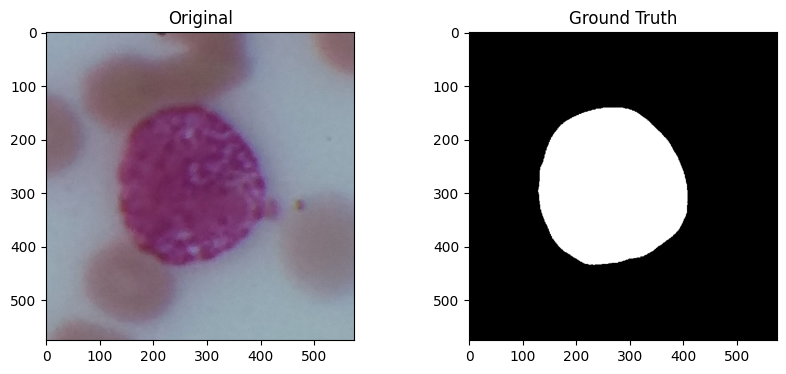

In [50]:
import cv2
import matplotlib.pyplot as plt

image = "/kaggle/input/raabin-wbc-segmentation/Train_bmp/20190526_163414_0.bmp"
gt_mask  = "/kaggle/input/raabin-wbc-segmentation/Train_GT_bmp/20190526_163414_0.bmp"

image = cv2.imread(image, cv2.COLOR_BGR2RGB)
gt = cv2.imread(gt_mask, cv2.IMREAD_GRAYSCALE)

mask = (gt > 0).astype(np.uint8)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(gt, cmap='gray')
plt.title("Ground Truth")

plt.show()


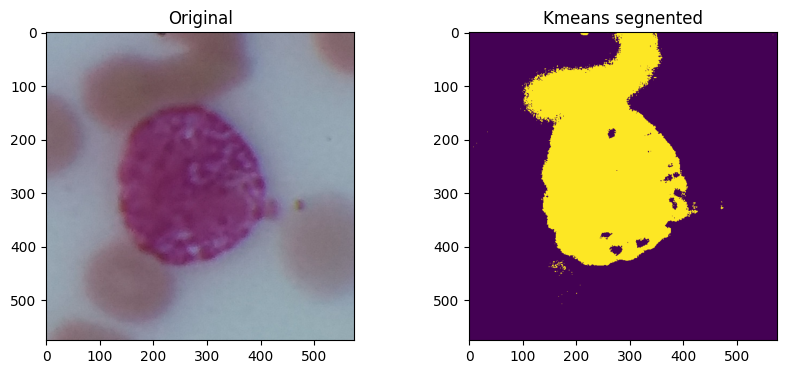

In [51]:
from sklearn.cluster import KMeans

pixels = image.reshape(-1, 3).astype(np.float32)

k=3
model = KMeans(n_clusters=k, random_state=42, n_init=10)
km_labels = model.fit_predict(pixels)
segmented_k = km_labels.reshape(image.shape[:2])

km_nucleus_idx = np.argmin(np.mean(model.cluster_centers_, axis=1))
km_mask = (segmented_k == km_nucleus_idx).astype(np.uint8)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(km_mask, cmap='viridis')
plt.title("Kmeans segnented")

plt.show()
  


In [52]:
!pip install scikit-fuzzy

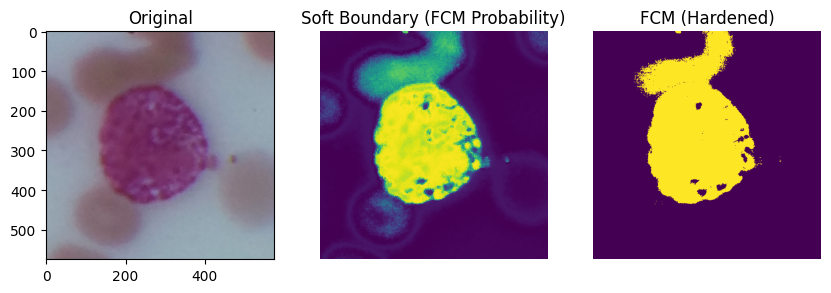

In [53]:
import skfuzzy as fuzz


c=3
m=2
maxiter=1000
   
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(pixels.T, c=c, m=m, error=0.005, maxiter=maxiter)

fcm_prob = u.reshape((c, image.shape[0], image.shape[1]))
fcm_labels = np.argmax(u, axis=0).reshape(image.shape[:2])

fcm_nucleus_idx = np.argmin(np.mean(cntr, axis=1))
fcm_mask = (fcm_labels == fcm_nucleus_idx).astype(np.uint8)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.title("Original")

plt.subplot(1,3,2)
plt.title("Soft Boundary (FCM Probability)")
nucleus_probs = fcm_prob[fcm_nucleus_idx]
plt.imshow(nucleus_probs, cmap='viridis') 
plt.axis('off')

plt.subplot(1,3,3)
plt.title(f"FCM (Hardened)")
plt.imshow(fcm_mask, cmap='viridis')
plt.axis('off')

plt.show()
  

(np.float64(-0.5), np.float64(574.5), np.float64(574.5), np.float64(-0.5))

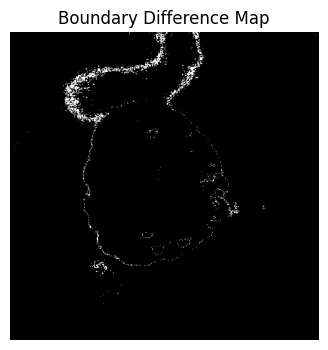

In [54]:
diff = np.abs(km_mask.astype(float) - fcm_mask.astype(float))

plt.figure(figsize=(10,4))
plt.imshow(diff, cmap='gray')
plt.title("Boundary Difference Map")
plt.axis('off')

In [55]:
from sklearn.metrics import jaccard_score

def get_metrics(gt, pred):
    iou = jaccard_score(gt.flatten(), pred.flatten(), average = 'binary')
    dice = (2 * iou) / (iou + 1)
    return iou, dice

km_iou, km_dice = get_metrics(mask, km_mask)
fcm_iou, fcm_dice = get_metrics(mask, fcm_mask)

print(f"K-Means Nucleus Dice: {km_dice:.4f}")
print(f"FCM Nucleus Dice: {fcm_dice:.4f}")

K-Means Nucleus Dice: 0.8123
FCM Nucleus Dice: 0.8290


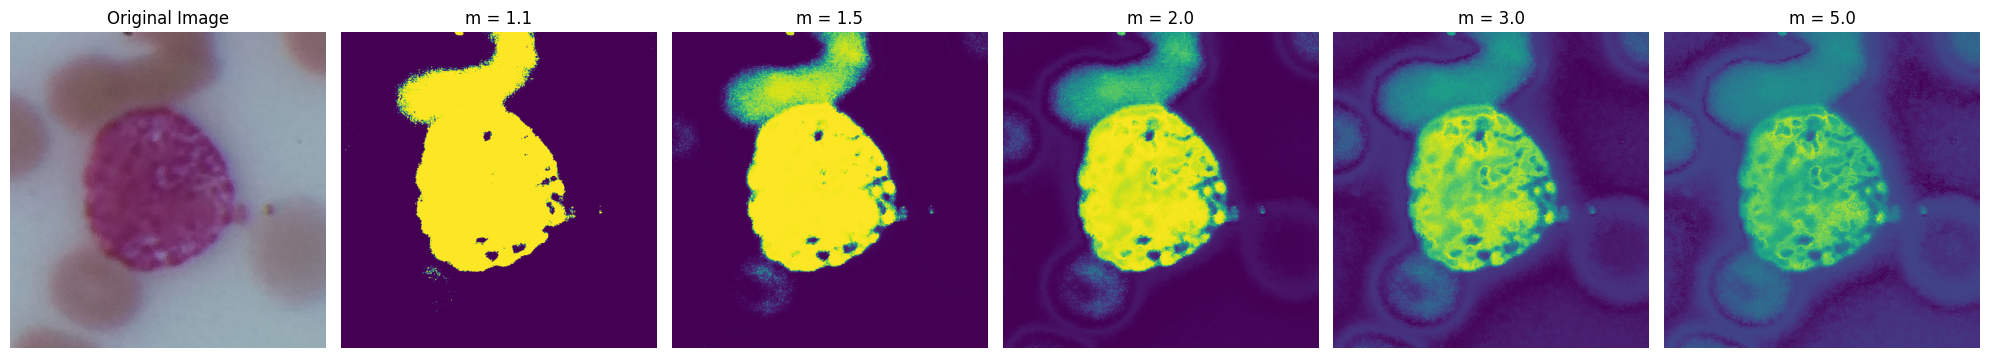

In [56]:
h, w = image.shape[:2]

m_values = [1.1, 1.5, 2.0, 3.0, 5.0]
plt.figure(figsize=(20, 10))

plt.subplot(1, len(m_values) + 1, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

for i, m in enumerate(m_values):
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        pixels.T, c=3, m=m, error=0.005, maxiter=500)
    
    nucleus_idx = np.argmin(np.mean(cntr, axis=1))
    
    probs = u.reshape((3, h, w))[nucleus_idx]

    plt.subplot(1, len(m_values) + 1, i + 2)
    plt.imshow(probs, cmap='viridis')
    plt.title(f"m = {m}")
    plt.axis('off')

plt.tight_layout()
plt.show()

**testing how m values affect**

In [57]:
import pandas as pd
import os

ORIGINAL_PATH = '/kaggle/input/raabin-wbc-segmentation/Train_bmp' 
GT_PATH = '/kaggle/input/raabin-wbc-segmentation/Train_GT_bmp'
num_to_test = 20

results = []

def get_dice(gt_mask, pred_mask):
    iou = jaccard_score(gt_mask.flatten(), pred_mask.flatten(), average='binary')
    return (2 * iou) / (iou + 1) if (iou + 1) != 0 else 0

def segment_wbc(image):
    h, w = image.shape[:2]
    pixels = image.reshape(-1, 3).astype(np.float32)
    
    km = KMeans(n_clusters=3, random_state=42, n_init=5).fit(pixels)
    km_centers_mean = np.mean(km.cluster_centers_, axis=1)
    km_idx = np.argsort(km_centers_mean)[0]
    km_mask = (km.labels_.reshape(h, w) == km_idx).astype(np.uint8)
    
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(pixels.T, c=3, m=2, error=0.005, maxiter=1000)
    fcm_idx = np.argmin(np.mean(cntr, axis=1))
    fcm_centers_mean = np.mean(cntr, axis=1)
    fcm_idx = np.argsort(fcm_centers_mean)[0]
    fcm_labels = np.argmax(u, axis=0).reshape(h, w)
    fcm_mask = (fcm_labels == fcm_idx).astype(np.uint8)
    
    return km_mask, fcm_mask

image_files = os.listdir(ORIGINAL_PATH)[:num_to_test]

for filename in image_files:
    
    img = cv2.imread(os.path.join(ORIGINAL_PATH, filename))
    gt = cv2.imread(os.path.join(GT_PATH, filename), 0)
    
    if img is not None and gt is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gt_bin = (gt == 255).astype(np.uint8)
        
        km_mask, fcm_mask = segment_wbc(img_rgb)
        km_dice = get_dice(gt_bin, km_mask)
        fcm_dice = get_dice(gt_bin, fcm_mask)
        
        results.append({'File': filename, 'KMeans_Dice': km_dice, 'FCM_Dice': fcm_dice})


df = pd.DataFrame(results)
print(df.describe())

       KMeans_Dice   FCM_Dice
count    20.000000  20.000000
mean      0.106945   0.106532
std       0.179444   0.176213
min       0.000000   0.000051
25%       0.010861   0.019436
50%       0.034061   0.030400
75%       0.090781   0.092087
max       0.645754   0.689617


**conclusion**

K-Means uses hard clustering where each pixel belongs to only one cluster, while Fuzzy C-Means uses soft clustering allowing partial membership. FCM provides better boundary handling, but both methods have limited accuracy without preprocessing.